# Tensor Hypercontraction

In this notebook we describe the implementation of SELECT and PREPARE for the tensor hypercontraction (THC) factorized form of the second quantized chemistry hamiltonian.
We will discuss the THC Hamiltonian (which asymptotically yields the lowest complexity of all second quantized algorithms), before discussing the symmetries which can be exploited, and finally provide circuits and costs for PREPARE and SELECT, comparing to available [reference values](https://arxiv.org/pdf/2011.03494.pdf) where possible.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran.drawing import show_bloq
from typing import *
import numpy as np
import cirq

## `State preparation`

PREPARE in THC requires state preparation to occur in two steps. In the first step we prepare a uniform superposition over a number of registers before we load the appropriate Hamiltonian coefficients which are defined over the registers we prepared in the first step. That is, if $H = \sum_{pq}^N \zeta_{pq} a^{\dagger}_p a_q$ then we need at least two registers ($p$ and $q$) each of size $\lceil \log N \rceil$ bits. The state we want to prepare is of the form $|\psi\rangle \sim \sum_{pq} \sqrt{\zeta_{pq}}|pq\rangle$. This second step usually involves loading the parameters in QROM (or more commonly QRO(A)M) before performing alias sampling to prepare the appropriate superposition state. At a high level step one usually has a logarithmic cost in the size of the registers, while step 2 has a cost that goes like $\sqrt{d}$ where $d$ is the amount of data to load and arises from the QROM circuit (in the above example $d = N^2$). As step 2 is typically **the** dominant cost in the second quantized algorithms, a lot of effort is placed on loading the **minimum** amount of data required to specify the Hamiltonian. In particular, the quantum chemistry Hamiltonian exhibits several symmetries which can be exploited to reduce the QROM cost by several factors of two.

### `Symmetries`

### `Simplified Example`

#### `Uniform superposition`
Before discussing the two THC PREPARE circuits, it is helpful to think about implementing a simplified state preparation circuit which can be analyzed more easily. Specifically let us consider the example above and try to implement the state

$$
|0\rangle^{\otimes 2 \log M} \rightarrow \frac{1}{\sqrt{\lambda}} \sum_{\mu\le\nu}^M\sqrt{\zeta_{\mu\nu}}|\mu\rangle|\nu\rangle,
$$
which demonstrates the main ideas. Above we are essentially assuming our matrix $\zeta$ is symmetric so that we only need to load $d = M (M+1)/2$ data rather than $M^2$ which is a modest, but useful improvement.
We will also assume for the moment that the matrix has all positive matrix elements.

Step 1 is to prepare a uniform superposition over our registers. We will use a single round of amplitude amplification to boost our success probability to close to 1. Our circuit is a simplified version of that given in Fig. 3 of [Ref 1](https://arxiv.org/pdf/2011.03494.pdf). Here it is: 

In [29]:
import numpy as np
import cirq_ft
from cirq_ft.infra import testing as cft_testing
from cirq_ft.infra.jupyter_tools import display_gate_and_compilation
from qualtran.bloqs.chemistry.thc_tutorial import UniformPrepareUpperTriangular

# dim := M here 
# Let's keep it simple with a 2x2 matrix to prepare
dim = 2
zeta = np.random.randint(0, 10, size=(dim, dim))

upper_triang = UniformPrepareUpperTriangular(n=dim)
context_manager = cirq_ft.GreedyQubitManager(prefix="_a", maximize_reuse=True)
upper_triang_gh = cft_testing.GateHelper(
    upper_triang, context=context_manager
)

display_gate_and_compilation(upper_triang_gh)

Walking through the circuit left to right we have:

1. Prepare a uniform superposition over the $p$ and $q$ registers with Hadamards with zero Toffoli cost.
2. We rotate an ancilla qubit by "adding a constant into a phase gradient register". There are a few things to unpack here:
    * The constant (i.e. angle) is given by $0.436 \pi = \arccos(1-8/10)$, where $8=2^{4-1}$ and $10 = 4 \times (4 + 1) / 2$. That is, (one minus) the ratio of the number of bits used needed to prepare our state and the amount of data we are going to prepare. The choice of this angle is described in more detail in the [amplitude amplification tutorial]().
    * The phase gradient register is a relatively cheap way to implement single qubit rotations fault tolerantly. For the moment let us just note that for us we need a single qubit $R_y$ gate and it costs b_r - 3 Toffolis, where $b_r=7$ is the number of bits used to represent the angle and this has found to be sufficient. See [techniques for single qubit rotations]() for further discussion on fault tolerant implementations of single qubit rotations.
3. Next we perform an inequality test on the $p$ and $q$ registers, and write the result of $p\le q$ into another ancilla register. This has cost n_p - 1 Toffolis where $n_p$ is the number of bits required to represent the range of $p$ values.
4. We use a Toffoli gate to control off of the result of the inequality test and the $Ry$ rotation. If both these succeed then we set the third ancilla to on and phase this ancilla with a $Z$ gate. We then undo the Toffoli. This step has a cost of 2 Toffoli gates and 1 Clifford operation.
5. We undo the inequality test and Hadamards and reflect around zero and apply the Hadamards again. The reflection has a Toffoli cost 2 n_p + 1

Phew! That's quite a lot just to prepare a uniform superposition state. Let's check our predicted T count (which we take from the THC paper) against that computed by our circuit: 

In [30]:
from cirq_ft.infra import t_complexity
tcomp_cirq = t_complexity(upper_triang)
n_p = 2 # we need 2 bits for our example
b_r = 7 # Taken from the THC reference.
# vs (only count toffolis)
# If we assume the same cost as cirq_ft for a Toffoli of 7 T gates then we multiply everything by 7
expected = 7 * (
    2*(b_r - 3) # 2x rotations
    +
    2*(n_p - 1)# 2x inequality
    +
    2 # Two Toffolis for phasing third ancilla.
    +
    2 * n_p + 1 # Cost for reflections
)
# Add in the cost of rotations to the cirq t complexity cost
print(f"Computed = {tcomp_cirq.t + 2*(b_r-3)*7} vs Expected = {expected}")
# print(f"Computed = {tcomp_cirq.t} vs Expected = {expected}. Difference = {tcomp_cirq.t-expected}.")

Computed = 102 vs Expected = 119


Oh no! Our computed estimate differs from our enumeration. What happened? We see that our calculated cost for the inequality tests is 24 T gates vs what we expect from $2\times7\times(n_p - 1) = 14$. Our computed reflections also cost 40 T gates rather 35 T gates which we expect. These two differences make up 10 + 5 = 15. These small differences highlight some of the complications which arise when trying to reproduce resource estimates `exactly`, i.e. the costs associated with different primitives may be slightly different than those listed in the paper, which is an unfortunate fact of life.

Anyway, let's move on and check that our circuit is actually correct. Here we will make use of some utility functions and analyze the statevector.

In [33]:
from qualtran.bloqs.chemistry.thc_tutorial import analyze_state_vector
state_vector = analyze_state_vector(upper_triang_gh, length=dim*dim)
print(cirq.dirac_notation(state_vector))

-0.58|01000⟩ - 0.58|01001⟩ - 0.58|01011⟩


We see that (as hoped), we have successfully prepared the state with $p \le q$, where $p$ is stored in binary in the first two bits and q the second two, and our normalization seems to be consistent. (What is cirq doing when I just provide the circuit and not the decomposed one?) 

#### `State Preparation`

Now that we have our initial state we can prepare our amplitudes using [coherent alias sampling](). Here is our simplified circuit:

In [44]:
from qualtran.bloqs.chemistry.thc_tutorial import PrepareUpperTriangular
flat_data = zeta[np.triu_indices(dim)]
assert len(flat_data) == dim * (dim + 1) // 2
lambda_zeta  = np.sum(np.abs(flat_data))
probs = flat_data / np.sqrt(lambda_zeta)
# number of bits of precision for lcu probabilities
mu = 3
prep = PrepareUpperTriangular.build(dim, probs, epsilon=2**-mu / len(probs))
ut_prep_gh = cft_testing.GateHelper(
    prep
)

display_gate_and_compilation(ut_prep_gh)

In [46]:
from qualtran.bloqs.chemistry.thc_tutorial import analyze_state_vector
state_vector = analyze_state_vector(ut_prep_gh, length=dim*dim)
print(state_vector)

ValueError: Input state must be normalized.

In [39]:
prep = cirq_ft.PrepareUniformSuperposition(3)
one_d_prep = cft_testing.GateHelper(
    prep
)
state_vector = analyze_state_vector(gate_helper, length=dim*dim)
print(state_vector*state_vector.conj())

[3.33333333e-01+0.j 3.33333333e-01+0.j 3.33333333e-01+0.j
 4.66075047e-32+0.j]


## `UniformSuperpositionTHC`
Prepare uniform superposition state for THC.

$$
    |0\rangle^{\otimes 2\log(M+1)} \rightarrow \sum_{\mu\le\nu}^{M} |\mu\rangle|\nu\rangle + \sum_{\mu}^{N/2}|\mu\rangle|\nu=M+1\rangle,
$$

where $M$ is the THC auxiliary dimension, and $N$ is the number of spin orbitals.

The toffoli complexity of this gate should be 10 * log(M+1) + 2 b_r - 9.
Currently it is a good deal larger due to:
    1. inverting inequality tests should not need more toffolis.
    2. We are not using phase-gradient gate toffoli cost for Ry rotations

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$ 

Registers:
- mu: $\mu$ register.
- nu: $\nu$ register.
- succ: ancilla flagging success of amplitude amplification.
- eq_nu_mp1: ancillas for flagging if $\nu = M+1$.

#### References
[Even more efficient quantum computations of chemistry through tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf). Eq. 29.


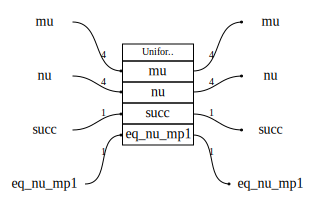

In [7]:
from qualtran.bloqs.chemistry.thc import UniformSuperpositionTHC

num_mu = 10
num_spin_orb = 4
bloq = UniformSuperpositionTHC(num_mu=num_mu, num_spin_orb=num_spin_orb)
show_bloq(bloq)

/tmp/ipykernel_2343258/3234429489.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


T-count:   492
Rotations: 0
Cliffords: 1124



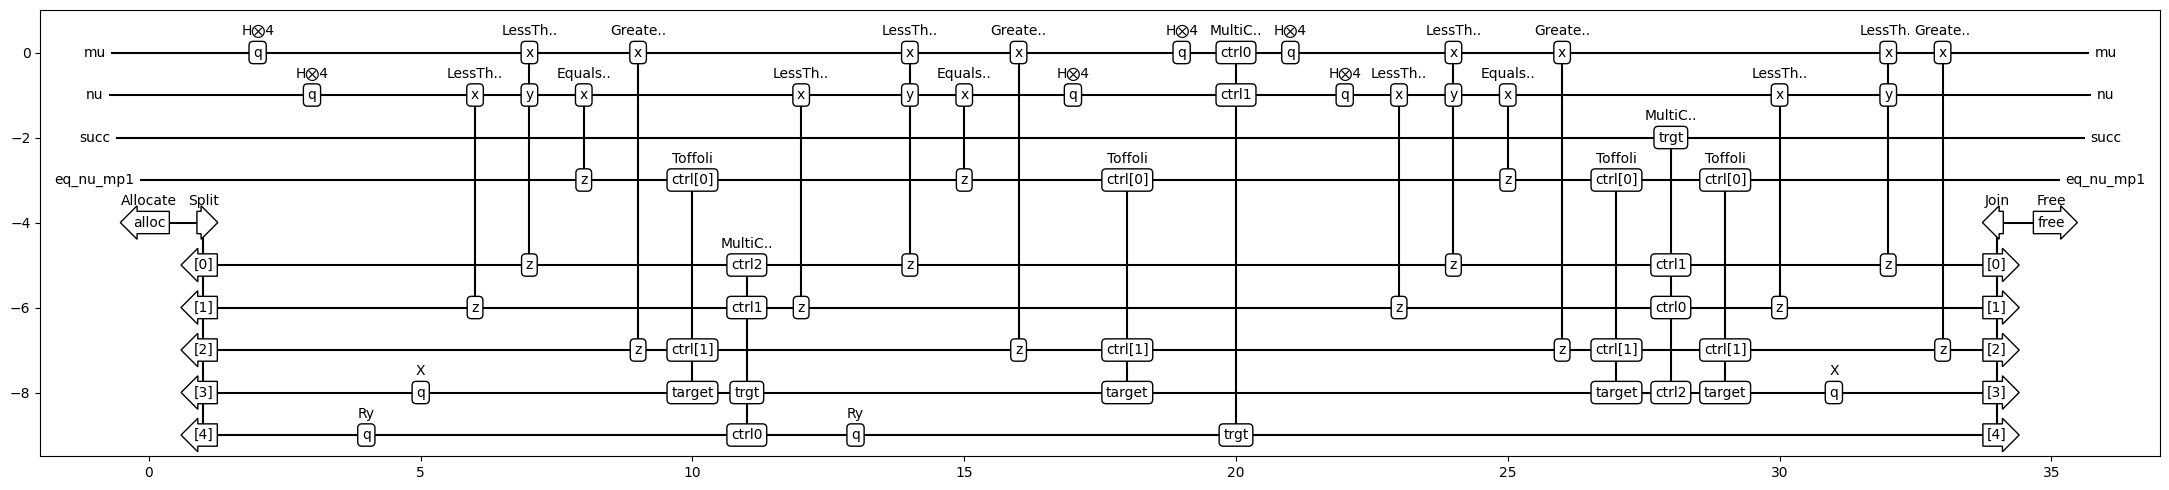

In [8]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
cbloq = bloq.decompose_bloq()
msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()
print(cbloq.t_complexity())

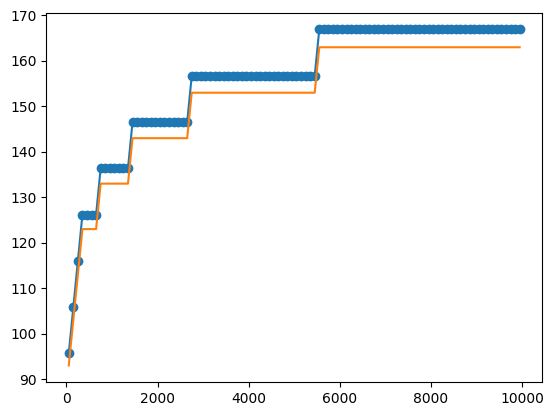

In [9]:
import matplotlib.pyplot as plt
t_comp = []
num_spatial = range(50, 10_000, 100)
for ns in num_spatial:
    bloq = UniformSuperpositionTHC(num_mu=6*ns, num_spin_orb=2*ns)
    t_comp.append(bloq.decompose_bloq().t_complexity().t)

plt.plot(num_spatial, np.array(t_comp)/11, marker='o')
plt.plot(num_spatial, 10*np.array([(6*ns).bit_length() for ns in num_spatial]) + 3)
# plt.yscale("log")
# plt.xscale("log")

## `PrepareTHC`
State Preparation for THC Hamilontian.

Prepares the state

$$
    \frac{1}{\sqrt{\lambda}}|+\rangle|+\rangle\left[
        \sum_\ell^{N/2} \sqrt{t_\ell}|\ell\rangle|M+1\rangle
        + \frac{1}{\sqrt{2}} \sum_{\mu\le\nu}^M \sqrt{\zeta_{\mu\nu}} |\mu\rangle|\nu\rangle
    \right].
$$

#### Parameters
 - `num_mu`: THC auxiliary index dimension $M$
 - `num_spin_orb`: number of spin orbitals $N$
 - `keep_bitsize`: number of bits for keep register for coherent alias sampling. 

Registers:
 - mu: $\mu$ register.
 - nu: $\nu$ register.
 - theta: sign register.

#### References
[Even more efficient quantum computations of chemistry through tensor hypercontraction](https://arxiv.org/pdf/2011.03494.pdf) Fig. 2 and Fig. 3.


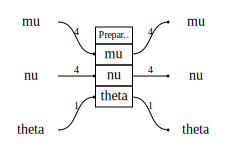

In [10]:
from qualtran.bloqs.chemistry.thc import PrepareTHC

num_mu = 10
num_spin_orb = 4

bloq = PrepareTHC(num_mu=num_mu, num_spin_orb=num_spin_orb, keep_bitsize=8)
show_bloq(bloq)

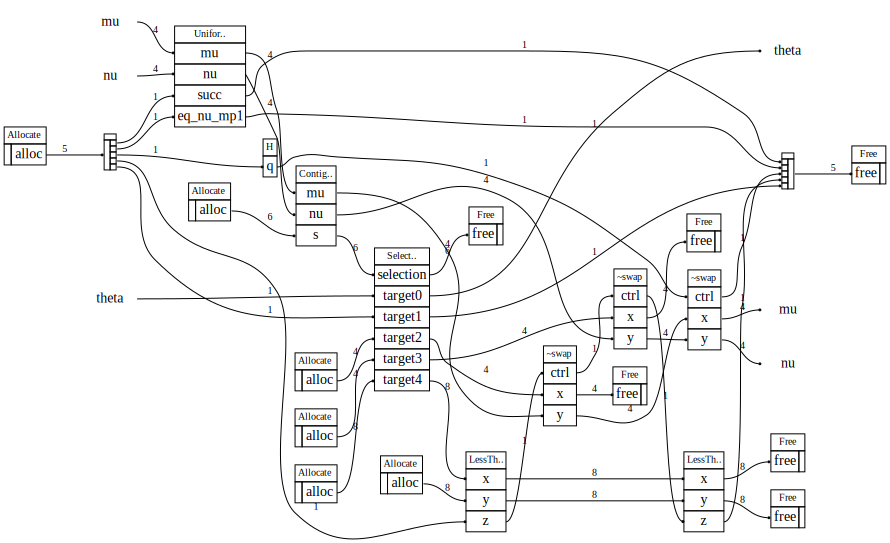

In [11]:
cbloq = bloq.decompose_bloq() 
show_bloq(cbloq)

/tmp/ipykernel_2343258/1409724447.py:5: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


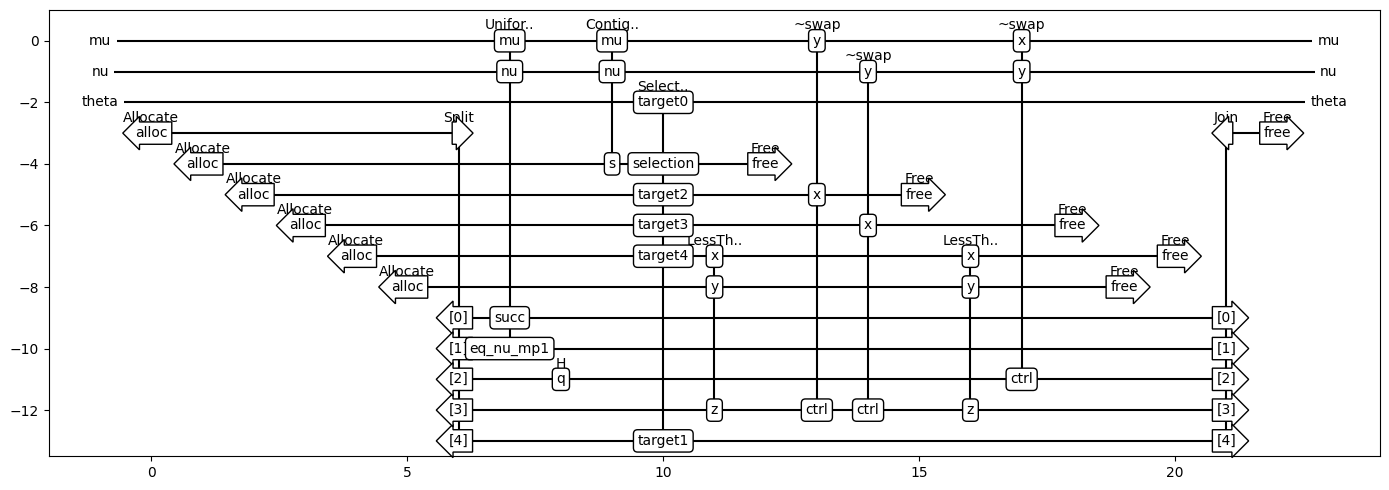

In [12]:
from qualtran.drawing import get_musical_score_data, draw_musical_score
cbloq = bloq.decompose_bloq()
msd = get_musical_score_data(cbloq)
fig, ax = draw_musical_score(msd)
fig.tight_layout()

In [13]:
print(cbloq.t_complexity())

T-count:   1240
Rotations: 0
Cliffords: 5484



In [14]:
%pip install openfermion
%pip install pyscf

Note: you may need to restart the kernel to use updated packages.
^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import numpy as np
from openfermion.resource_estimates.utils import QR, QI
def prepare_cost(M, n, chi, stps):
    # The number of bits used for each register.
    nM = np.ceil(np.log2(M + 1))
    # This is the number of distinct items of data we need to output.
    d = M * (M + 1) // 2 + n // 2
    # The number of bits used for the contiguous register.
    # and 2 for the two sign bits, as in Eq. (29).
    m = 2 * nM + 2 + chi
    # Set it to be the number of bits that minimises the cost, usually 7.
    # Python is 0-index, so need to add the one back in vs mathematica nb
    br = 7 + 1

    # This is the costing for preparing the equal superposition over the
    # input registers from below Eq. (27).
    cp1 = 2 * (10 * nM + 2 * br - 9)

    # This is the cost of computing the contiguous register and inverting it.
    # This is with a sophisticated scheme adding together triplets of bits.
    # This is the cost of step 2 in the list on pages 15 and 16, with a factor
    # of 2 to account for its inverse.
    cp2 = 2 * (nM**2 + nM - 1)

    # This is the cost of the QROM for the state preparation in step 3 and its
    # inverse. Note: arg_min is first value, min is second value
    cp3 = QR(d, m)[1] + QI(d)[1]

    # The cost for the inequality test in step 4 and its inverse.
    cp4 = 2 * chi

    # The cost 2*nM for the controlled swap in step 5 and its inverse.
    cp5 = 4 * nM

    # Then there is a cost of nM + 1 for swapping the mu and nu registers in
    # step 6, where the + 1 is because we need to control on two registers.
    # There is the same cost for the inverse.
    cp6 = 2 * nM + 2

    # This is the total cost in Eq. (32).
    print(cp1, cp2, cp3, cp4, cp5, cp6)
    CPCP = cp1 + cp2 + cp3 + cp4 + cp5 + cp6
    return CPCP

In [ ]:
import matplotlib.pyplot as plt
t_comp = []
t_comp_of = []
num_spatial = range(10, 100, 100)
for ns in num_spatial:
    print(ns)
    bloq = PrepareTHC(num_mu=6*ns, num_spin_orb=2*ns, keep_bitsize=12)
    bloq2 = UniformSuperpositionTHC(num_mu=6*ns, num_spin_orb=2*ns)
    t_comp.append(bloq.decompose_bloq().t_complexity().t-bloq2.decompose_bloq().t_complexity().t)
    t_comp_of.append(prepare_cost(6*ns, 2*ns, 12, 10))

plt.xscale("log")
plt.yscale("log")
plt.plot(num_spatial, np.array(t_comp), marker='o')
plt.plot(num_spatial, np.array(t_comp_of), marker='^')